## Image Classification with PyTorch
 "Traditionally, the only way to get a computer to do something -- from adding two numbers to flying an airplane --was to write down an algorithm explaining how, in painstaking detail. But machine learning, also known as learners, are different: they figure it out on their own, by making inferences from data. And the more data they have, the better the get. Now we don't have to program computers: they program themselves." (from "The Master Algorithm by Pedro Domingo)   
  
Image Classification is a supervised learning problem: define a set of target classes (objects to identify in images), and train a model to recognize them using labeled example photos.

This notebook presents the techniques using PyTorch from the series https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans applied to the **CIFAR100** dataset.  

I learned a lot. I also learned that I just scratched the surface; there's still deep learning and countless hours of training I need before I can comfortably say - yes "I GOT IT!"



In [3]:
!pip install jovian --upgrade --quiet

In [ ]:
#import os
import torch
import torchvision
import numpy as np
#import tarfile
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.datasets.utils import download_url
from torchvision.datasets import CIFAR100
#from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### CIFAR100 Dataset

<img src="https://miro.medium.com/max/700/0*fqFMfJeP6CuBTuYc.png" style="max-width:480px">


In [4]:
project_name='image-classification-project-2021'

### Download the Dataset

In [ ]:
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_ds = CIFAR100(root = 'data/', train = False, transform = ToTensor())
#train_dataset = CIFAR100(root = 'data/', download = True, transform = train_transform)
#test_dataset = CIFAR100(root = 'data/', train = False, transform = test_transform)

Extracting data/cifar-100-python.tar.gz to data/


### Explore the Dataset

In [ ]:
print(dataset)
print(test_ds)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
dataset_size = len(dataset)
test_ds_size = len(test_ds)
print('total images  in dataset:', dataset_size)
print('total images in test dataset:', test_ds_size)

total images  in dataset: 50000
total images in test dataset: 10000


Let's find out how many output classes CIFAR100 has

In [ ]:
print('total classes:', len(dataset.classes))
print(dataset.classes)

total classes: 100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'wha

Let's find out the shape of an image tensor from our dataset

In [ ]:
for img, label in dataset:
  print('img.shape: ', img.shape)
  print('label: ', label)
  print()
  print('img tensor: ') 
  print(img)
  break

img.shape:  torch.Size([3, 32, 32])
label:  19

img tensor: 
tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.8314, 0.7137],
         [1.0000, 0.9961, 0.9961,  ..., 0.6667, 0.6314, 0.5725],
         [1.0000, 0.9961, 1.0000,  ..., 0.7412, 0.6510, 0.4745],
         ...,
         [0.5804, 0.5569, 0.5490,  ..., 0.1176, 0.2549, 0.2980],
         [0.4784, 0.4706, 0.4941,  ..., 0.0863, 0.3804, 0.5529],
         [0.3412, 0.3451, 0.3961,  ..., 0.1333, 0.4118, 0.5412]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8784, 0.7608],
         [1.0000, 0.9961, 0.9961,  ..., 0.6902, 0.6588, 0.6039],
         [1.0000, 0.9961, 1.0000,  ..., 0.7804, 0.6980, 0.5216],
         ...,
         [0.7255, 0.7137, 0.7020,  ..., 0.0667, 0.2431, 0.3020],
         [0.6157, 0.6078, 0.6275,  ..., 0.0627, 0.4392, 0.6314],
         [0.4784, 0.4784, 0.5255,  ..., 0.1412, 0.5216, 0.6784]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.8000, 0.6549],
         [1.0000, 0.9961, 0.9961,  ..., 0.5882, 0.5098, 0.4431

In [ ]:
dataset_classes_dict = dict()

for item in dataset:
    label = dataset.classes[item[1]]
    if label in dataset_classes_dict:
      dataset_classes_dict[label] += 1
    else:
      dataset_classes_dict[label] = 1

dataset_classes_dict

{'apple': 500,
 'aquarium_fish': 500,
 'baby': 500,
 'bear': 500,
 'beaver': 500,
 'bed': 500,
 'bee': 500,
 'beetle': 500,
 'bicycle': 500,
 'bottle': 500,
 'bowl': 500,
 'boy': 500,
 'bridge': 500,
 'bus': 500,
 'butterfly': 500,
 'camel': 500,
 'can': 500,
 'castle': 500,
 'caterpillar': 500,
 'cattle': 500,
 'chair': 500,
 'chimpanzee': 500,
 'clock': 500,
 'cloud': 500,
 'cockroach': 500,
 'couch': 500,
 'crab': 500,
 'crocodile': 500,
 'cup': 500,
 'dinosaur': 500,
 'dolphin': 500,
 'elephant': 500,
 'flatfish': 500,
 'forest': 500,
 'fox': 500,
 'girl': 500,
 'hamster': 500,
 'house': 500,
 'kangaroo': 500,
 'keyboard': 500,
 'lamp': 500,
 'lawn_mower': 500,
 'leopard': 500,
 'lion': 500,
 'lizard': 500,
 'lobster': 500,
 'man': 500,
 'maple_tree': 500,
 'motorcycle': 500,
 'mountain': 500,
 'mouse': 500,
 'mushroom': 500,
 'oak_tree': 500,
 'orange': 500,
 'orchid': 500,
 'otter': 500,
 'palm_tree': 500,
 'pear': 500,
 'pickup_truck': 500,
 'pine_tree': 500,
 'plain': 500,
 'pl

In [ ]:
test_classes_dict = dict()

for test_item in test_ds:
    label = test_ds.classes[test_item[1]]
    if label in test_classes_dict:
      test_classes_dict[label] += 1
    else:
      test_classes_dict[label] = 1

test_classes_dict

{'apple': 100,
 'aquarium_fish': 100,
 'baby': 100,
 'bear': 100,
 'beaver': 100,
 'bed': 100,
 'bee': 100,
 'beetle': 100,
 'bicycle': 100,
 'bottle': 100,
 'bowl': 100,
 'boy': 100,
 'bridge': 100,
 'bus': 100,
 'butterfly': 100,
 'camel': 100,
 'can': 100,
 'castle': 100,
 'caterpillar': 100,
 'cattle': 100,
 'chair': 100,
 'chimpanzee': 100,
 'clock': 100,
 'cloud': 100,
 'cockroach': 100,
 'couch': 100,
 'crab': 100,
 'crocodile': 100,
 'cup': 100,
 'dinosaur': 100,
 'dolphin': 100,
 'elephant': 100,
 'flatfish': 100,
 'forest': 100,
 'fox': 100,
 'girl': 100,
 'hamster': 100,
 'house': 100,
 'kangaroo': 100,
 'keyboard': 100,
 'lamp': 100,
 'lawn_mower': 100,
 'leopard': 100,
 'lion': 100,
 'lizard': 100,
 'lobster': 100,
 'man': 100,
 'maple_tree': 100,
 'motorcycle': 100,
 'mountain': 100,
 'mouse': 100,
 'mushroom': 100,
 'oak_tree': 100,
 'orange': 100,
 'orchid': 100,
 'otter': 100,
 'palm_tree': 100,
 'pear': 100,
 'pickup_truck': 100,
 'pine_tree': 100,
 'plain': 100,
 'pl

### View some elements in the dataset

We can view the image using matplotlib, but we need to change the tensor dimensions to (32,32,3). Let's create a helper function to display an image and its label.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  cattle (19)


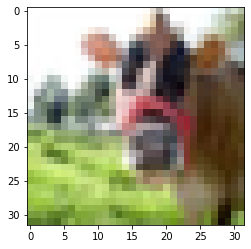

In [ ]:
img, label = dataset[0]
show_example(img, label)

Label:  rose (70)


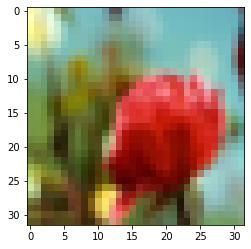

In [ ]:
show_example(*dataset[7500])

### Save and upload our notebook to Jovian


In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

## Prepare the Data for Training

In [ ]:
random_seed = 43
torch.manual_seed(random_seed);

#### Use `random_split` method to create the training and validation sets

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print('total images in our training set: ', len(train_ds))
print('total images in our validation set: ', len(val_ds))

total images in our training set:  40000
total images in our validation set:  10000


The jovian library also provides a simple API for recording important parameters related to the dataset, model training, results etc. for easy reference and comparison between multiple experiments. Let's record dataset_url, val_pct and rand_seed using jovian.log_dataset.

In [ ]:
# from torchvision.datasets import CIFAR100
dataset_url = 'https://www.cs.toronto.edu/~kriz/cifar.html'
jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

[jovian] Dataset logged.


#### Define the data loaders for training and validation, to load the data in batches

In [ ]:
batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

val_dl = DataLoader(val_ds, 
                    batch_size,       # note lesson on feedforward has the *2
                    num_workers=4, 
                    pin_memory=True)

test_dl = DataLoader(test_ds, 
                    batch_size,      # note lesson on feedforward has *2 batch_size
                    num_workers=4, 
                    pin_memory=True)

### Visualize a batch of data using the `make_grid` helper from Torchvision

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

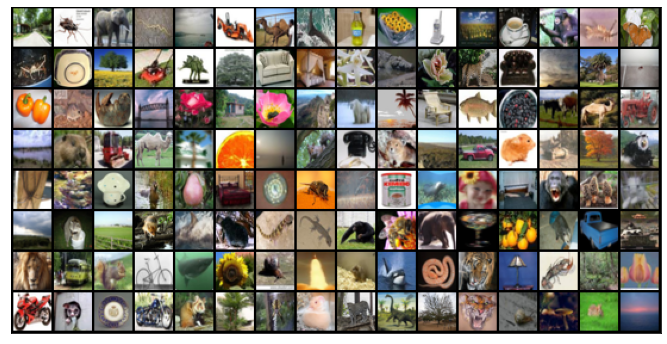

In [ ]:
show_batch(train_dl)

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

### Settings: Device and DeviceDataLoaders
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

Let's move our data loaders to the appropriate device.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Let us also define a couple of helper functions for plotting the losses & accuracies.

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's create a base model class, which contains everything except the model architecture i.e. IT WILL NOT CONTAIN the __init__ and __forward__ methods. 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## Train our First Model Using Feed Forward
"A feedforward network is a network that contains inputs, outputs, and hidden layers. The signals can only travel in one direction (forward). Input data passes into a layer where calculations are performed. Each processing element computes based upon the weighted sum of its inputs. The new values become the new input values that feed the next layer (feed-forward). This continues through all the layers and determines the output."    

Source: https://towardsdatascience.com/simply-deep-learning-an-effortless-introduction-45591a1c4abb

In [ ]:
input_size = 3*32*32      #3*32*32=3072
output_size = len(dataset.classes)
hidden_size1 = 1034 
hidden_size2 = 1034 

In [ ]:
class CIFAR100Model(ImageClassificationBase):     # feed forward
    def __init__(self):
        super().__init__()
        # hidden layers
        self.linear1a = nn.Linear(input_size, hidden_size1)
        self.linear1b = nn.Linear(hidden_size1, hidden_size2)
        self.linear2 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        xb = xb.view(xb.size(0), -1)

        # Apply hidden layers & activation functions
        out = self.linear1a(xb)
        out = F.relu(out)
        out = self.linear1b(out)
        out = F.relu(out)

        #apply output layer
        out = self.linear2(out)
        return out

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


Now instantiate the model, and move it the appropriate device.



In [ ]:
model_ff = to_device(CIFAR100Model(), device)

Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [ ]:
history_ff = [evaluate(model_ff, val_dl)]
history_ff

[{'val_acc': 0.01068037934601307, 'val_loss': 4.6069231033325195}]

Train the model using the fit function to reduce the validation loss & improve accuracy.  


In [ ]:
history_ff += fit(30, 0.1, model_ff, train_dl, val_dl)

Epoch [0], val_loss: 4.0449, val_acc: 0.0824
Epoch [1], val_loss: 3.8735, val_acc: 0.1056
Epoch [2], val_loss: 3.7286, val_acc: 0.1280
Epoch [3], val_loss: 3.6479, val_acc: 0.1408
Epoch [4], val_loss: 3.6600, val_acc: 0.1497
Epoch [5], val_loss: 3.5546, val_acc: 0.1585
Epoch [6], val_loss: 3.5533, val_acc: 0.1702
Epoch [7], val_loss: 3.5672, val_acc: 0.1691
Epoch [8], val_loss: 3.3534, val_acc: 0.2009
Epoch [9], val_loss: 3.3793, val_acc: 0.1975
Epoch [10], val_loss: 3.3574, val_acc: 0.2002
Epoch [11], val_loss: 3.3141, val_acc: 0.2111
Epoch [12], val_loss: 3.4315, val_acc: 0.1900
Epoch [13], val_loss: 3.3081, val_acc: 0.2084
Epoch [14], val_loss: 3.2463, val_acc: 0.2253
Epoch [15], val_loss: 3.3202, val_acc: 0.2179
Epoch [16], val_loss: 3.2573, val_acc: 0.2228
Epoch [17], val_loss: 3.2403, val_acc: 0.2314
Epoch [18], val_loss: 3.2819, val_acc: 0.2258
Epoch [19], val_loss: 3.2591, val_acc: 0.2334
Epoch [20], val_loss: 3.3017, val_acc: 0.2241
Epoch [21], val_loss: 3.4450, val_acc: 0.209

In [ ]:
history_ff += fit(20, 0.01, model_ff, train_dl, val_dl)

Epoch [0], val_loss: 3.1604, val_acc: 0.2850
Epoch [1], val_loss: 3.1674, val_acc: 0.2885
Epoch [2], val_loss: 3.1711, val_acc: 0.2856
Epoch [3], val_loss: 3.1871, val_acc: 0.2848
Epoch [4], val_loss: 3.1815, val_acc: 0.2871
Epoch [5], val_loss: 3.1906, val_acc: 0.2856
Epoch [6], val_loss: 3.1939, val_acc: 0.2857
Epoch [7], val_loss: 3.2063, val_acc: 0.2863
Epoch [8], val_loss: 3.2096, val_acc: 0.2871
Epoch [9], val_loss: 3.2035, val_acc: 0.2872
Epoch [10], val_loss: 3.2174, val_acc: 0.2814
Epoch [11], val_loss: 3.2201, val_acc: 0.2852
Epoch [12], val_loss: 3.2196, val_acc: 0.2867
Epoch [13], val_loss: 3.2156, val_acc: 0.2870
Epoch [14], val_loss: 3.2289, val_acc: 0.2860
Epoch [15], val_loss: 3.2305, val_acc: 0.2842
Epoch [16], val_loss: 3.2421, val_acc: 0.2823
Epoch [17], val_loss: 3.2387, val_acc: 0.2853
Epoch [18], val_loss: 3.2496, val_acc: 0.2833
Epoch [19], val_loss: 3.2692, val_acc: 0.2839


In [ ]:
history_ff += fit(10, 0.001, model_ff, train_dl, val_dl)

Epoch [0], val_loss: 3.2446, val_acc: 0.2860
Epoch [1], val_loss: 3.2459, val_acc: 0.2876
Epoch [2], val_loss: 3.2464, val_acc: 0.2864
Epoch [3], val_loss: 3.2468, val_acc: 0.2861
Epoch [4], val_loss: 3.2471, val_acc: 0.2862
Epoch [5], val_loss: 3.2480, val_acc: 0.2872
Epoch [6], val_loss: 3.2477, val_acc: 0.2868
Epoch [7], val_loss: 3.2499, val_acc: 0.2860
Epoch [8], val_loss: 3.2490, val_acc: 0.2869
Epoch [9], val_loss: 3.2512, val_acc: 0.2861


Plot the losses and the accuracies to check if you're starting to hit the limits of how well your model can perform on this dataset. 

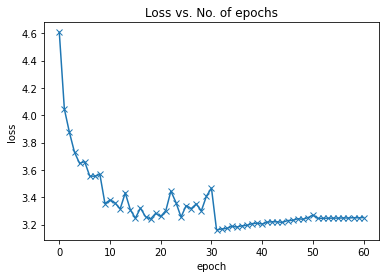

In [ ]:
plot_losses(history_ff)

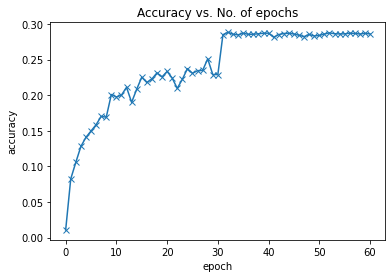

In [ ]:
plot_accuracies(history_ff)

In [ ]:
test_ff = evaluate(model_ff, test_dl)
test_ff

{'val_acc': 0.296281635761261, 'val_loss': 3.228579521179199}

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

Record our results for feed forward and include the following:  
* the model's architecture
* learning rates used
* number of epochs per layer


In [ ]:
arch_ff = "4 layers (1034, 1034, 10)"
lrs_ff = [0.1, 0.01, 0.001]
epochs_ff = [30, 20, 10]

In [ ]:
test_acc_ff = 0.296281635761261
test_loss_ff = 3.228579521179199

In [ ]:
torch.save(model_ff.state_dict(), 'cifar100-feedforward.pth')

The jovian library provides some utility functions to keep your work organized. With every version of your notebook, you can attach some hyperparameters and metrics from your experiment.

In [ ]:
# Clear previously recorded hyperparams & metrics
jovian.reset()

In [ ]:
jovian.log_hyperparams(arch=arch_ff, 
                       lrs=lrs_ff, 
                       epochs=epochs_ff)

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(test_loss=test_loss_ff, test_acc=test_acc_ff)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, outputs=['cifar100-feedforward.pth'], environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

## Train our Second Model - Convolutional Neural Networks  
The convolutional neural network (CNN) is a class of deep learning neural networks. They can be found at the core of everything from Facebook’s photo tagging to self-driving cars. They’re working hard behind the scenes in everything from healthcare to security.   
#### A CNN has
* Convolutional layers
* ReLU layers
* Pooling layers
* a Fully connected layer  
 
Source: https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb

Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.  
We'll use nn.Sequential to chain the layers and activations functions into a single network architecture.

In [ ]:
class Cifar100CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # output: 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # output: 64 x 32 x 32
            nn.ReLU(),
            # output: 64 x 32 x 32
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
# the torch.no_grad only applies during the evaluate phase
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model_cnn = to_device(Cifar100CnnModel(), device)
model_cnn

Cifar100CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [ ]:
history_cnn = [evaluate(model_cnn, val_dl)]
history_cnn

[{'val_acc': 0.009098101407289505, 'val_loss': 4.605696201324463}]

Train our CNN Model for CIFAR100

In [ ]:
num_epochs_cnn = 20
opt_func = torch.optim.Adam
lr_cnn = 0.001

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs_cnn,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr_cnn,
})

[jovian] Hyperparams logged.


In [ ]:
%%time
history_cnn = fit(num_epochs_cnn, lr_cnn, model_cnn, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 3.9782, val_acc: 0.0712
Epoch [1], val_loss: 3.5055, val_acc: 0.1513
Epoch [2], val_loss: 3.2247, val_acc: 0.2066
Epoch [3], val_loss: 2.9864, val_acc: 0.2552
Epoch [4], val_loss: 2.8120, val_acc: 0.2988
Epoch [5], val_loss: 2.7137, val_acc: 0.3208
Epoch [6], val_loss: 2.6248, val_acc: 0.3468
Epoch [7], val_loss: 2.6485, val_acc: 0.3487
Epoch [8], val_loss: 2.6681, val_acc: 0.3591
Epoch [9], val_loss: 2.8115, val_acc: 0.3616
Epoch [10], val_loss: 3.1148, val_acc: 0.3554
Epoch [11], val_loss: 3.6211, val_acc: 0.3427
Epoch [12], val_loss: 3.8963, val_acc: 0.3436
Epoch [13], val_loss: 4.4802, val_acc: 0.3405
Epoch [14], val_loss: 4.9442, val_acc: 0.3342
Epoch [15], val_loss: 5.0891, val_acc: 0.3386
Epoch [16], val_loss: 5.7842, val_acc: 0.3390
Epoch [17], val_loss: 6.1024, val_acc: 0.3406
Epoch [18], val_loss: 6.0822, val_acc: 0.3364
Epoch [19], val_loss: 6.5672, val_acc: 0.3332
CPU times: user 1min 27s, sys: 29.4 s, total: 1min 57s
Wall time: 2min 40s


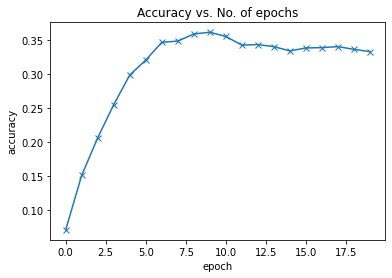

In [ ]:
plot_accuracies(history_cnn)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

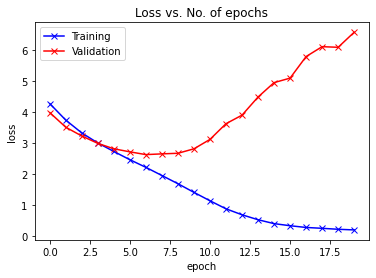

In [ ]:
plot_losses(history_cnn)

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

Test Individual Images

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: lamp , Predicted: lamp


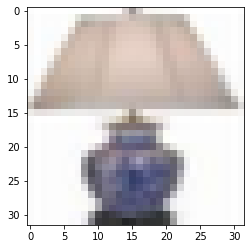

In [ ]:
img, label = test_ds[3002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_cnn))

Label: otter , Predicted: beaver


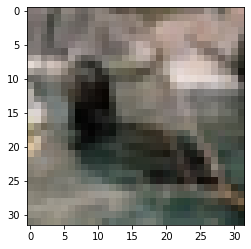

In [ ]:
img, label = test_ds[6090]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_cnn))

In [ ]:
test_cnn = evaluate(model_cnn, test_dl) 
test_cnn

{'val_acc': 0.3400909900665283, 'val_loss': 6.585507869720459}

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result_cnn = evaluate(model_cnn, test_dl)
result_cnn

{'val_acc': 0.34052735567092896, 'val_loss': 6.577862739562988}

In [ ]:
jovian.log_metrics(test_loss=result_cnn['val_loss'], test_acc=result_cnn['val_acc'])

[jovian] Metrics logged.


Save and Load the Model

In [ ]:
torch.save(model_cnn.state_dict(), 'cifar100-cnn.pth')

In [ ]:
model_cnn = to_device(Cifar100CnnModel(), device)

In [ ]:
model_cnn.load_state_dict(torch.load('cifar100-cnn.pth'))

<All keys matched successfully>

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/tessdja/image-classification-project-2021


'https://jovian.ai/tessdja/image-classification-project-2021'

## Train our Third Model using ResNets, Regularization and Data Augmentation

In [ ]:
import torchvision.transforms as tt
# Data transforms (normalization & data augmentation)
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) - cifar10
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))      #cifar100

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = CIFAR100(root = 'data/', download = True, transform = train_tfms)
valid_ds = CIFAR100(root = 'data/', train = False, transform = valid_tfms)

Files already downloaded and verified


In [ ]:
batch_size = 400

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)         # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)      # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))  # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True)    # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)    # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))  # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),     # 512
                                        nn.Dropout(0.2),  
                                        nn.Linear(512, num_classes)) # 100
        
    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out = self.classifier(out6)
        return out

In [ ]:
model_resnet9 = to_device(ResNet9(3, 100), device)
model_resnet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# call model eval before doing any evaluation - good practice
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()      
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history_resnet9 = [evaluate(model_resnet9, valid_dl)]
history_resnet9

[{'val_acc': 0.010192306712269783, 'val_loss': 4.606661319732666}]

In [ ]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history_resnet9 += fit_one_cycle(epochs, max_lr, model_resnet9, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], val_loss: 3.3334, val_acc: 0.2116
Epoch [1], val_loss: 3.0590, val_acc: 0.2588
Epoch [2], val_loss: 2.9106, val_acc: 0.3071
Epoch [3], val_loss: 2.7076, val_acc: 0.3263
Epoch [4], val_loss: 2.2511, val_acc: 0.4113
Epoch [5], val_loss: 2.1415, val_acc: 0.4477
Epoch [6], val_loss: 2.0699, val_acc: 0.4509
Epoch [7], val_loss: 1.8794, val_acc: 0.4968
Epoch [8], val_loss: 1.9268, val_acc: 0.4820
Epoch [9], val_loss: 1.9698, val_acc: 0.4931
Epoch [10], val_loss: 1.7396, val_acc: 0.5333
Epoch [11], val_loss: 1.8415, val_acc: 0.5072
Epoch [12], val_loss: 2.4879, val_acc: 0.4127
Epoch [13], val_loss: 1.8858, val_acc: 0.4923
Epoch [14], val_loss: 1.8047, val_acc: 0.5096
Epoch [15], val_loss: 1.5638, val_acc: 0.5689
Epoch [16], val_loss: 1.9669, val_acc: 0.5138
Epoch [17], val_loss: 2.6831, val_acc: 0.3936
Epoch [18], val_loss: 1.6076, val_acc: 0.5571
Epoch [19], val_loss: 1.6234, val_acc: 0.5553
Epoch [20], val_loss: 1.7769, val_acc: 0.5344
Epoch [21], val_loss: 1.5302, val_acc: 0.569

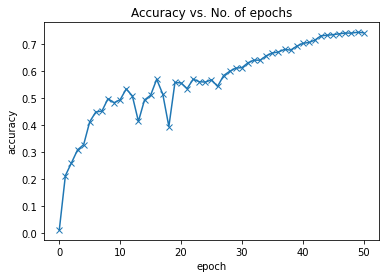

In [ ]:
plot_accuracies(history_resnet9)

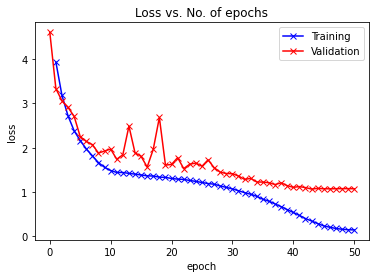

In [ ]:
plot_losses(history_resnet9)

In [ ]:
def plot_lrs(history_resnet9):
    lrs = np.concatenate([x.get('lrs', []) for x in history_resnet9])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

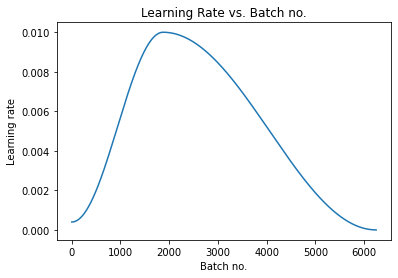

In [ ]:
plot_lrs(history_resnet9)

Label: mountain , Predicted: road


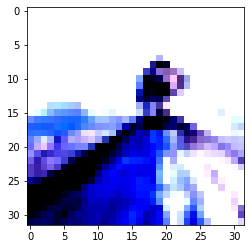

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model_resnet9))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: wardrobe , Predicted: wardrobe


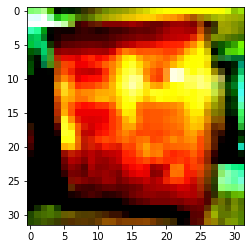

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model_resnet9))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: spider , Predicted: spider


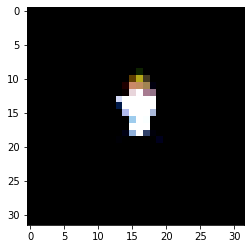

In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model_resnet9))

In [ ]:
torch.save(model_resnet9.state_dict(), 'cifar100-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

## Summary of my CIFAR100 Training Results:  
Based on the 3 Model Architecture, I got the following  loss and accuracy:  
 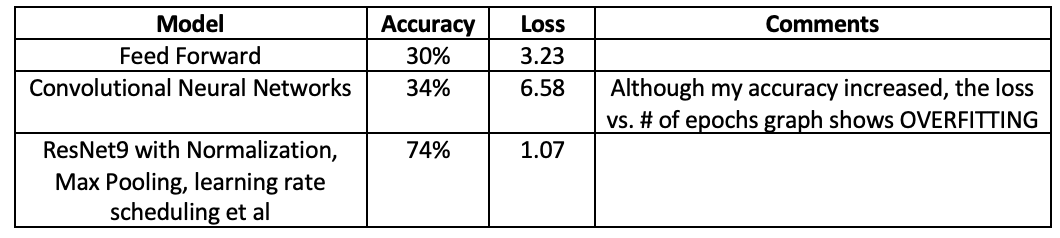

Now, enjoy a 2D visualization of CNN using the digits of the MNIST classes: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html  

## References and Further Exploration:
Complete PyTorch Documentation: https://pytorch.org/  

Easy to follow concepts on Statistics, Machine and Deep Learning from Josh Starmer as he serenades you at the beginning of each tutorial in you tube: https://www.youtube.com/user/joshstarmer     

Complete Beginners Guide to Deep Learning by Anne Bonner: https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb  

Andrew Ng's thorough approach of the Mathematics behind Machine Learning and Deep Learning: 
* https://www.coursera.org/learn/machine-learning/
* https://www.deeplearning.ai/   

The Master Algorithm Book by Pedro Domingos: https://en.wikipedia.org/wiki/The_Master_Algorithm   

Again, thanks Aakash and Team for this well-organized presentation. I like your approach to teach first by doing and seeing the process behind the concept. This gives the learner a good framework to understand and master those concepts further. 